# Classification - Double-down vs Hit vs Stay 

This notebook is for model building of the classification model to predict what is the best action to take next.

<u>***Setup***</u>

In [1]:
import os,copy
import sqlite3 as sql
import numpy as np

import pandas as pd
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt

import torch as tc
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm

## Pulling data

This is simply to connect to the db and pull the data to see what it looks like

In [2]:
# Specify the absolute path to the database file
db_file_path = '../data/game_state.db'

# Check if the database file exists
if os.path.exists(db_file_path):
    conn = sql.connect(db_file_path)
    hitstay_df = pd.read_sql_query('SELECT * FROM players_hitStay', conn)
else:
    print("Database file not found.")


In [3]:
print(f"{hitstay_df.shape=}")
hitstay_df.tail(10)

hitstay_df.shape=(338, 14)


,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
328,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,9,PC-1,1,150.0,205.0,405,"(Hr 5,Di 8,Cl 8)",21,0,House,Hr A,11,stay
329,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,9,House,0,150.0,0.0,405,"(Cl 10,Hr A)",21,0,House,Hr A,11,stay
330,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,10,Albert,0,150.0,150.0,150,"(Hr 2,Hr 4)",6,0,House,Hr 10,10,double-down
331,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,10,Albert,0,150.0,300.0,150,"(Hr 2,Hr 4,Di A)",17,0,House,Hr 10,10,hit
332,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,10,Albert,0,150.0,300.0,150,"(Hr 2,Hr 4,Di A,Hr 5)",12,0,House,Hr 10,10,hit
333,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,10,Albert,0,150.0,300.0,150,"(Hr 2,Hr 4,Di A,Hr 5,Di 7)",19,0,House,Hr 10,10,stay
334,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,10,PC-1,1,150.0,215.0,365,"(Cl 3,Sp A)",14,0,House,Hr 10,10,hit
335,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,10,PC-1,1,150.0,215.0,365,"(Cl 3,Sp A,Di 5)",19,0,House,Hr 10,10,stay
336,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,10,House,0,150.0,0.0,365,"(Sp 6,Hr 10)",16,0,House,Hr 10,10,hit
337,b6f9a566-a2bd-48ea-a5b9-fb94612642fe,10,House,0,150.0,0.0,365,"(Sp 6,Hr 10,Sp 5)",21,0,House,Sp 5,5,stay


## Analysis

Here is a quick EDA to see what the lay of the land is in the data

In [4]:
dec_grp_df = hitstay_df.groupby(['player_choice','player_is_pc']) \
    .agg(decision_count=('player_name','count')) \
        .reset_index() \
            .sort_values('decision_count',ascending=False) \
                .fillna(0)

dec_grp_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).head()

player_is_pc,0,1
player_choice,,
bust,36.0,6.0
double-down,29.0,0.0
hit,82.0,38.0
stay,105.0,42.0


> **COMMENT**: 
>
> From the above it is obvious that the `double-down` feature has not been implemented in the PC-player decisioning workflow. This is fine. The classifier we are building is only for the human player assistance.
>
> The PC-player data will still be used to train the classifier, since the PC-player has a considerable amount of success with its simple heuristic. I want to incorporate this decisioning in the classifier.

,player_choice,player_is_pc,decision_count
5,stay,0,105
3,hit,0,82
6,stay,1,42
4,hit,1,38
0,bust,0,36
2,double-down,0,29
1,bust,1,6


<Axes: xlabel='player_choice'>

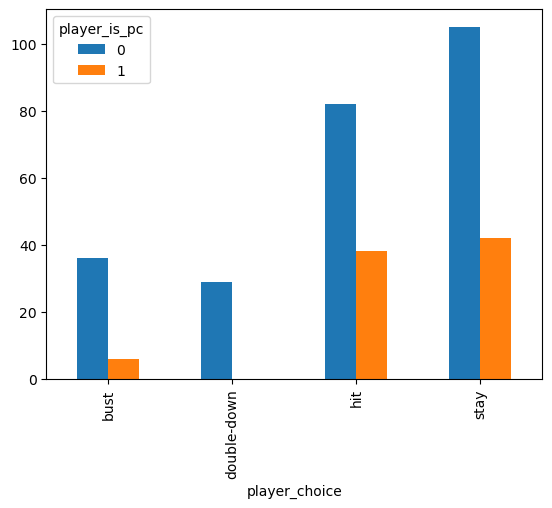

In [5]:
display(dec_grp_df.head(10))
# dec_grp_df.plot.bar(x='player_choice',y='decision_count')
dec_grp_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).plot.bar()


player_is_pc,0,1
player_choice,,
bust,36,6
hit,111,38
stay,105,42


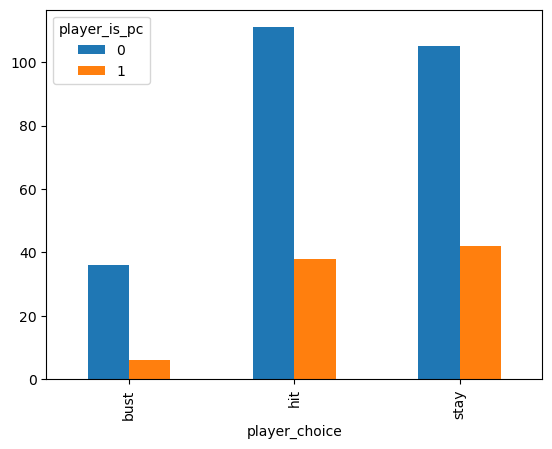

In [6]:
dec_grp_rebase_df = dec_grp_df.copy()
dec_grp_rebase_df['player_choice'] = dec_grp_rebase_df['player_choice'].apply(lambda x: 'hit' if x == 'double-down' else x)
dec_grp_rebase_df = dec_grp_rebase_df.groupby(['player_choice','player_is_pc']).agg(decision_count=('decision_count','sum')).reset_index()
dec_grp_rebase_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').fillna(0).plot.bar()
display(dec_grp_rebase_df.pivot(index='player_choice',columns='player_is_pc',values='decision_count').head(10))

> **COMMENT**:
>
> When incorporating the `double-down` decision as a `hit` decision, the `hit` vs `stay` decision ratio is very similar between the PC and human player. This is considering that there are two human players and one PC player created by default when running the game, which is what was used when creating this data.
>
> It is glaringly obvious that there is much less bust results from the PC player, when compared to the human players.

### Assigning Wins

This section is particularly important. It is the result of the choices made by the player to see if they had beaten the House.

The result of the below can be used in many different ways (re-inforcement learning, optimization of game play, etc.), and is hence mentioned and handled specifically.

In [7]:
select_cols = ["game_ID","roundNumber","player_name","player_cards","player_choice","player_hand","row_number"]

## Assigning row_number()
hitstay_df = hitstay_df.assign(
        row_number=hitstay_df.sort_index()
        .groupby(["game_ID","roundNumber","player_name"])
        .cumcount()
        + 1)

## Getting final row of each player in that round
hitstay_df['player_final_row'] = hitstay_df.groupby(['game_ID','roundNumber','player_name'])['row_number'].transform('max')
select_cols.append('player_final_row')

## Getting the house final hand
# Step 1: Filter to get the house's final row for each game and round
house_final = hitstay_df.loc[(hitstay_df['player_name'] == 'House') & (hitstay_df['row_number'] == hitstay_df['player_final_row'])]
# Rename the player_hand column to house_final_score
house_final = house_final[['game_ID', 'roundNumber', 'player_hand']].rename(columns={'player_hand': 'house_final_hand'})
# Step 2: Merge this information back to the original dataframe
hitstay_df = hitstay_df.merge(house_final, on=['game_ID', 'roundNumber'], how='left')
select_cols.append('house_final_hand')

## Getting the player result
# Step 1: Filter to get the house's final row for each game and round
player_final = hitstay_df.loc[(hitstay_df['player_name'] != 'House') & (hitstay_df['row_number'] == hitstay_df['player_final_row'])].copy()
player_final['player_result'] = player_final.apply(lambda x: 'Win' if 
                ((x.house_final_hand < x.player_hand) and (x.player_hand <= 21)) or
                ((x.house_final_hand > 21) and (x.player_hand <= 21))
                else 'Draw' if
                ((x.house_final_hand == x.player_hand) and (x.player_hand <= 21))
                else 'Bust' if (x.player_hand > 21) else 'Lost', axis=1)
# # Rename the player_hand column to house_final_score
player_final = player_final[['game_ID', 'roundNumber', 'player_result','player_name']]
# Step 2: Merge this information back to the original dataframe
hitstay_df = hitstay_df.merge(player_final, on=['game_ID', 'roundNumber','player_name'], how='left')

hitstay_df['player_result'] = hitstay_df['player_result'].fillna('NotApplicable')

select_cols.append('player_result')


hitstay_df[select_cols].head(15)

,game_ID,roundNumber,player_name,player_cards,player_choice,player_hand,row_number,player_final_row,house_final_hand,player_result
0,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,"(Di 2,Sp A)",hit,13,1,3,24,Win
1,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,"(Di 2,Sp A,Cl Q)",hit,13,2,3,24,Win
2,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Joe,"(Di 2,Sp A,Cl Q,Cl 5)",stay,18,3,3,24,Win
3,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,"(Hr 2,Sp K)",hit,12,1,2,24,Bust
4,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,"(Hr 2,Sp K,Cl J)",bust,22,2,2,24,Bust
5,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,"(Hr 6,Di 9)",hit,15,1,2,24,Win
6,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,PC-1,"(Hr 6,Di 9,Sp 6)",stay,21,2,2,24,Win
7,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,House,"(Sp 4,Hr 7)",hit,11,1,3,24,NotApplicable
8,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,House,"(Sp 4,Hr 7,Cl 3)",hit,14,2,3,24,NotApplicable
9,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,House,"(Sp 4,Hr 7,Cl 3,Sp J)",bust,24,3,3,24,NotApplicable


player_is_pc,0,1
player_result,,
Bust,21,6
Draw,6,4
Lost,25,17
Win,37,25


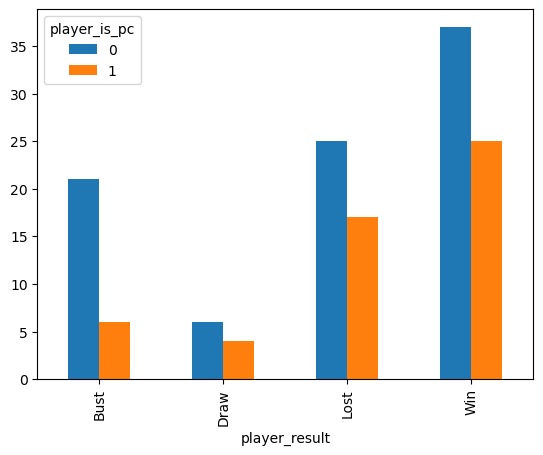

In [15]:
result_grp_df = hitstay_df.loc[hitstay_df.player_name != 'House'].groupby(['game_ID','roundNumber','player_result','player_is_pc']) \
    .agg(decision_count=('player_name','nunique')) \
        .reset_index() \
            .groupby(['player_result','player_is_pc']) \
                .agg(decision_count=('decision_count','sum')) \
                    .reset_index() \
                        .head(10)

result_grp_df.pivot(index='player_result',columns='player_is_pc',values='decision_count').fillna(0).plot.bar()
display(result_grp_df.pivot(index='player_result',columns='player_is_pc',values='decision_count').head(10))

In [ ]:
## Getting the player result
# Step 1: Filter to get the house's final row for each game and round
player_final = hitstay_df.loc[(hitstay_df['player_name'] != 'House') & (hitstay_df['row_number'] == hitstay_df['player_final_row'])]
player_final['player_result'] = player_final.assign(lambda x: 'Win' if 
                ((x.house_final_hand < x.player_hand) and (x.player_hand <= 21)) or
                ((x.house_final_hand > 21) and (x.player_hand <= 21))
                else 'Draw' if
                ((x.house_final_hand == x.player_hand) and (x.player_hand <= 21))
                else 'Bust' if (x.player_hand > 21) else 'Lost', axis=1)
# # Rename the player_hand column to house_final_score
player_final = player_final[['game_ID', 'roundNumber', 'player_result','player_name']]
# Step 2: Merge this information back to the original dataframe
df = hitstay_df.merge(player_final, on=['game_ID', 'roundNumber','player_name'], how='left')
select_cols.append('player_result')


df[select_cols].head(20)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
hitstay_df.loc[hitstay_df.player_choice == 'double-down'].head()

,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
11,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,50.0,100,"(Cl A,Sp 3)",14,0,House,Sp A,11,double-down
16,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,100.0,200,"(Hr 6,Hr 2)",8,0,House,Sp 5,5,double-down
23,d9dfe2f1-826e-4ab1-9d40-439b2d613905,3,Joe,0,75.0,75.0,75,"(Sp 6,Hr 2)",8,0,House,Di 6,6,double-down
28,f8ee0a9c-0288-4407-86de-cc0a49531194,0,Joe,0,50.0,70.0,70,"(Hr 9,Sp 4)",13,0,House,Di 7,7,double-down
34,f8ee0a9c-0288-4407-86de-cc0a49531194,1,Albert,0,50.0,70.0,140,"(Sp 10,Di 4)",14,0,House,Cl 4,4,double-down


In [ ]:
hitstay_df.loc[(hitstay_df.game_ID == 'd9dfe2f1-826e-4ab1-9d40-439b2d613905') & (hitstay_df.player_name == 'Albert')].head(10)

,game_ID,roundNumber,player_name,player_is_pc,round_initial_bet,player_bet,game_pot,player_cards,player_hand,player_bust,house_name,house_visible_card,house_visible_hand,player_choice
3,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K)",12,0,House,Hr 7,7,hit
4,d9dfe2f1-826e-4ab1-9d40-439b2d613905,0,Albert,0,50.0,70.0,140,"(Hr 2,Sp K,Cl J)",22,1,House,Hr 7,7,bust
11,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,50.0,100,"(Cl A,Sp 3)",14,0,House,Sp A,11,double-down
12,d9dfe2f1-826e-4ab1-9d40-439b2d613905,1,Albert,0,50.0,100.0,100,"(Cl A,Sp 3,Cl 7)",21,0,House,Sp A,11,stay
16,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,100.0,200,"(Hr 6,Hr 2)",8,0,House,Sp 5,5,double-down
17,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,200.0,200,"(Hr 6,Hr 2,Cl 5)",13,0,House,Sp 5,5,hit
18,d9dfe2f1-826e-4ab1-9d40-439b2d613905,2,Albert,0,50.0,200.0,200,"(Hr 6,Hr 2,Cl 5,Cl 9)",22,1,House,Sp 5,5,bust


## Data manipulation

In this section, the data to be used for classification is worked with.

The relevent data to this classification problem is:
1. `player_bet`
2. `player_cards`
3. `house_visible_card`

Initially, the classification was only binary ('**stay**' or '**hit**'), however with the addition of the '**double-down**' option, this became a multi-class problem (at least for the first decision).

I would still like to build this as a binary-classification, and use logistic regression as a base model. The reason for logisitic regression is, I would like to build the model from first principles. Then I would like to build a NN, and lastly I will include other multi-class classifiers from sklearn.

The data would be done a bit different for each step, and that is fine for then. For now only focus on the binary classification and swop the '**double-down**' option for a normal '**hit**' option.

In order to train "*good*" behavior, I will test and see if it will work to treat the pen-ultimate decision as '`stay`' if the ultimate result was a '`bust`'.

> ***NOTE***:
> 
> For the first part I will exclude the `House` from the dataset. The behavior in the logging is different for `House`. There can be a separate model developed solely for the `House`

In [ ]:
select_cols = ['player_hand','house_visible_hand','house_card','player_bet','player_cards']

players_df = hitstay_df.loc[hitstay_df.player_name != 'House'].copy()
players_df['house_card'] = players_df.house_visible_card.str.split().str[1]

_, card_col_no = players_df.player_cards.str.replace("(","").str.replace(")","").str.split(",",expand=True).shape
card_cols = [f"card_{i+1}" for i in np.arange(card_col_no)]
select_cols.extend(card_cols)

players_df[card_cols] = players_df.player_cards.str.replace("(","").str.replace(")","").str.split(",",expand=True)
for col in card_cols:
    players_df[col] = players_df[col].str.split().str[1]

## Not sure if 0 is better than None. I think None will help a bit more...
# players_df[card_cols] = players_df[card_cols].fillna(value=0)

players_df[select_cols].head()

,player_hand,house_visible_hand,house_card,player_bet,player_cards,card_1,card_2,card_3,card_4,card_5
0,13,7,7,70.0,"(Di 2,Sp A)",2,A,None,None,None
1,13,7,7,70.0,"(Di 2,Sp A,Cl Q)",2,A,Q,None,None
2,18,7,7,70.0,"(Di 2,Sp A,Cl Q,Cl 5)",2,A,Q,5,None
3,12,7,7,70.0,"(Hr 2,Sp K)",2,K,None,None,None
4,22,7,7,70.0,"(Hr 2,Sp K,Cl J)",2,K,J,None,None


### Dummy columns

Dummy variables are created based on the player's cards

In [ ]:
def check_and_order_columns(df,ordered_list):
    df_cols = df.columns; df_rows, _ = df.shape
    mis_cols = [c for c in ordered_list if c not in df_cols]
    if len(mis_cols) > 0:
        for mc in mis_cols:
            df[mc] = np.zeros(df_rows).astype(int)
    return (mis_cols, df[ordered_list].copy())

def create_addative_dummy_matrix(df,columns_to_dummy,dummy_columns):
    ret_df = pd.get_dummies(df[columns_to_dummy[0]]).astype(int)
    for col in columns_to_dummy[1:]:
        ret_df = ret_df.add(pd.get_dummies(df[col]),fill_value=0).astype(int)
    mis_cols,ret_df = check_and_order_columns(ret_df,dummy_columns)
    return (mis_cols,ret_df)

In [ ]:
dummy_columns = ['2','3','4','5','6','7','8','9','10','J','Q','K','A']
mis_dummy_cols, dummy_df = create_addative_dummy_matrix(df=players_df, columns_to_dummy=card_cols,dummy_columns=dummy_columns)

## Adding the house_visible_card in
dummy_df = dummy_df.add(pd.get_dummies(players_df.house_card).astype(int)*-0.5, fill_value=0)
mis_dummy_cols_2, dummy_df = check_and_order_columns(dummy_df,dummy_columns)

print(f"dummy_df [{dummy_df.shape=}] ({mis_dummy_cols=}) ({mis_dummy_cols_2=})")
display(dummy_df.head())

dummy_df [dummy_df.shape=(192, 13)] (mis_dummy_cols=[]) (mis_dummy_cols_2=[])


,2,3,4,5,6,7,8,9,10,J,Q,K,A
0,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
## Just checking the additions
dummy_df.join(players_df[['house_card','player_cards',*card_cols]],how='left').head()

,2,3,4,5,6,7,8,9,10,J,Q,K,A,house_card,player_cards,card_1,card_2,card_3,card_4,card_5
0,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,"(Di 2,Sp A)",2,A,None,None,None
1,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7,"(Di 2,Sp A,Cl Q)",2,A,Q,None,None
2,1.0,0.0,0.0,1.0,0.0,-0.5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7,"(Di 2,Sp A,Cl Q,Cl 5)",2,A,Q,5,None
3,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,"(Hr 2,Sp K)",2,K,None,None,None
4,1.0,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7,"(Hr 2,Sp K,Cl J)",2,K,J,None,None


### Normalize player bet

The above dummy features have a small scale. I need to normalize (standardize according to sklearn) `player_bet` in order to not have the magnitude influence the decision immensely.

There is going to be leakage in the way that I am going to apply it, however it is allowable, since the assumption is that all bets will be drawn from the same distribution, irrespective of when it is made.

,player_bet,player_bet_norm
count,192.000000,1.920000e+02
mean,122.145833,7.401487e-17
std,72.634418,1.000000e+00
min,50.000000,-9.932734e-01
25%,70.000000,-7.179218e-01
50%,100.000000,-3.048945e-01
75%,150.000000,3.834844e-01
max,450.000000,4.513758e+00


<Axes: xlabel='roundNumber', ylabel='player_bet_norm'>

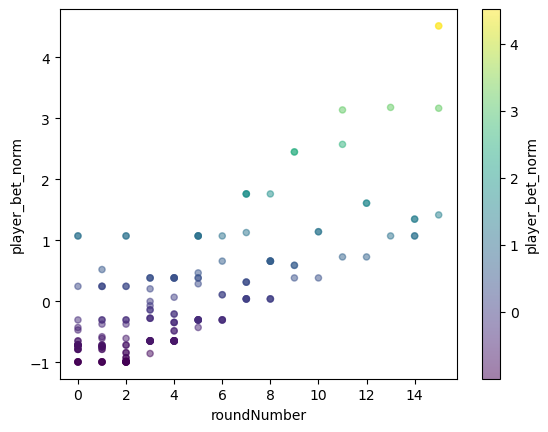

In [ ]:
players_df['player_bet_norm'] = (players_df.player_bet - players_df.player_bet.mean())/players_df.player_bet.std()
# players_df[['player_bet','player_bet_norm']].head(20)
display(players_df[['player_bet','player_bet_norm']].describe())
players_df.plot.scatter(y='player_bet_norm',x='roundNumber',c='player_bet_norm',colormap='viridis',alpha=0.5)

### Creating the label

There are two ways in which I can handle working with the '**bust**' decisions:
1. Simply remove the '**bust**' decisions
2. Remove any '**bust**' "*decision*"s and turn the previous ones into '**stay**' decisions

Since this is a game of chance, applying (1) probably makes more sense. However, in the interest of training a model to make the best decisions (2) also carries some weight.